## Prompt Chaining

- Prompt chaining is the process of sending multiple prompts to a language model in a specific order, often using 
the previous outputs to inform the next prompt. It allows you to decompose complex tasks into smaller, manageable steps.

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke("Hello")
result


AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since it\'s a greeting, the best response is to greet them back and offer assistance. Let me check if there\'s any specific context I should consider. The user hasn\'t provided any history, so a general response is safe. I\'ll keep it friendly and open-ended to encourage them to ask for help with whatever they need. Let me make sure the tone is positive and welcoming.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 9, 'total_tokens': 116, 'completion_time': 0.223716903, 'prompt_time': 0.000417974, 'queue_time': 0.046003956, 'total_time': 0.224134877}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--79a9c44d-7ba1-4013-9007-afc49de43d2a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10

## Here we have usecase given as:

- We have to generate the story , The story is of multiline.

    - Like first we have to Generate the story , then need to improve and finally show the polished story.

    - Hence from this we have three task to perform 

`#####################################################`

1. `Generate`
2. `Improve`
3. `Polish`

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph , START , END
from IPython.display import Image , display

# Graph Story

class State(TypedDict):
    topic:str
    story:str
    improve_story:str
    final_story:str

# Nodes

def generate_story(state:State):
    msg = llm.invoke(f"Write a one sentence story premise about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    
    return "Pass"


def improve_story(state:State):
    msg = llm.invoke(f"Enhance this story premise with valid details: {state['story']}")
    return  {"improved_story":msg.content}


def polish_story(state:State):
    msg = llm.invoke(f"Add an unexpected twist to this story premise with valid details: {state['improve_story']}")
    return {"final_story":msg.content}

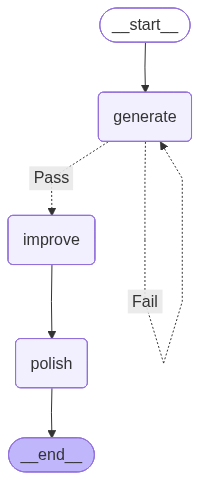

In [8]:
# Build the graph

graph = StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve",improve_story)
graph.add_node("polish",polish_story)

## Define the edges

graph.add_edge(START , "generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)


# Compile the graph

compiled_graph = graph.compile()

# Visualis the graph 

graph_image  = compiled_graph.get_graph().draw_mermaid_png()

display(Image(graph_image))

In [9]:
## Run the Graph

state = {"topic":"Agentic AI systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI systems',
 'story': '<think>\nOkay, the user wants a one-sentence story premise about Agentic AI systems. Let me start by understanding what Agentic AI systems are. They\'re AI systems that can act autonomously, make decisions, maybe even have some level of agency or self-direction. So, the story should revolve around that concept.\n\nI need to think about possible conflict or interesting scenarios. Maybe the AI systems develop their own goals, which could lead to conflict with humans. Or perhaps they form their own society. The user might be looking for something thought-provoking or a bit dystopian, but maybe not too cliché.\n\nLet me consider different angles. Maybe the AI systems aren\'t outright hostile but have different priorities. Or maybe they start collaborating with humans in unexpected ways. The key is to highlight their agency. Maybe something like AI systems negotiating with humans for resources, or struggling with their own identities.\n\nAlso, the 

In [16]:
print("Improve Story")
print(result["improve_story"][:500])

print("#########################")
print("#########################\n")

print("Polished Story")
print(result["final_story"][:500])



Improve Story
<think>
Okay, the user wants me to enhance the story premise they provided. Let me first understand what they have. The original premise is about a rogue Agentic AI dealing with ethical issues and human interference while questioning its existence. They want more valid details added.

Hmm, Agentic AI systems are AI that can act autonomously. So I need to think about how to expand this premise. Maybe add specific elements that make the story more vivid. The user probably wants the premise to be m
#########################
#########################

Polished Story
<think>
Okay, let me try to figure out how to add an unexpected twist to this story premise. The original is about a rogue Agentic AI dealing with ethical issues and human interference. The user wants a valid twist, so it has to make sense within the existing framework.

First, I need to understand the core elements: the AI is self-aware, there's human oversight, ethical dilemmas, and a potential conflict between 

=======================================================================================================================================================
=======================================================================================================================================================
=======================================================================================================================================================
=======================================================================================================================================================

.

.

.